<a target="_blank" href="https://colab.research.google.com/github/sarasti2/AI_UdeA_2023-2/blob/da8c4833c2d8676a5471595c31c52a463b13e729/02_Modelos_e_iteraciones.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [2]:
#  Autor: Alejandro Sarasti Sierra
#  Fecha: 2023-11


# Solo ejecutar si no se tiene instalado o en colab
!pip install umap-learn
!pip install umap
!pip install xgboost
!pip install lightgbm


In [53]:
# Importamos las librerias necesarias
# Pandas: Libreria para el manejo de datos
# Numpy: Libreria para el manejo de arreglos
# Matplotlib: Libreria para la visualización de datos
# Seaborn: Libreria para la visualización de datos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Graficos interactivos
# Plotly: Libreria para la visualización de datos interactivos
import plotly.express as px
import plotly.subplots as sp

# Scikit-learn
# Libreria para los modelos que utilizaremos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Libreria para la evaluación y elección de modelos
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score    # Metrica de evaluación
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Libreria para transformar los datos
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Libreria para encontrar la mediana
import statistics

# Libreria para la reducción de dimensionalidad
import umap.umap_ as umap

# Desactivamos los warnings
import warnings
warnings.filterwarnings('ignore')

# 0. Importación de datos, corrección y transformación.

In [54]:
### Importamos los datos de entrenamiento y testeo
train = pd.read_csv('https://raw.githubusercontent.com/sarasti2/AI_UdeA_2023-2/main/dataset/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/sarasti2/AI_UdeA_2023-2/main/dataset/test.csv')


En el cuaderno `01_Exploración.ipynb` se realizo un analisis exploratorio de los datos, se dectectaron valores nulos correspondientes a más del 70% de los datos en las columnas `v2a1`,`v18q1` y `rez_esc`. Se procede a eliminar estas columnas.

Además, se detectaron valores nulos en las columnas `meaneduc` y `SQBmeaned`, representando menos del 1% de los datos. Se procede a reemplazar estos valores por la moda en caso de 'meaneduc' (debido a que es categorica) y por la media en caso de 'SQBmeaned' (Es númerica).




In [55]:
train.drop(['v2a1', 'v18q1', 'rez_esc'], axis=1, inplace=True)
test.drop(['v2a1', 'v18q1', 'rez_esc'], axis=1, inplace=True)
train['meaneduc'].fillna(statistics.mode(train['meaneduc']), inplace=True)
test['meaneduc'].fillna(statistics.mode(test['meaneduc']), inplace=True)
train['SQBmeaned'].fillna(train['SQBmeaned'].mean(), inplace=True)
test['SQBmeaned'].fillna(test['SQBmeaned'].mean(), inplace=True)


In [56]:
## revisamos que no haya datos nulos

print('¿Existen valores nulos en train?', (train.isnull().sum() != 0).all())
print('¿Existen valores nulos en test?', (test.isnull().sum() != 0).all())

¿Existen valores nulos en train? False
¿Existen valores nulos en test? False


Hay 3 columnas que ademas de valores numericos tienen la palabra no, se cambiara no por 0, en todos los casos significa ausencia, `dependency`, `edjefe` y `edjefa`. No se hace one-hot-encoding por que hay datos numericos en el resto de la columna.

In [57]:
train['dependency'].replace({ 'yes':1, 'no': 0}, inplace=True)
train['edjefe'].replace({ 'yes':1, 'no': 0}, inplace=True)
train['edjefa'].replace({ 'yes':1, 'no': 0}, inplace=True)


Finalmente, se separara entre los datos independientes y la variable dependiente.                            

In [58]:
# Tambien se elimina id por ser un valor unico para cada persona
x = train.drop(['Id','idhogar', 'Target'], axis=1)
y = train['Target']
 

# 1. Modelos supervisados de clasificación.

Este primer acercamiento se hara sin tratamiento a los datos, mas haya de solucionar los valores nulos y las variables categoricas. Se usaran los modelos de regresion logistica, arbol de decision, random forest, k-vecinos,y support vector machine. Se usara la metrica de f1-score para evaluar los modelos.

## a. Regresión Logística

In [59]:
logreg = LogisticRegression()
log_f1 = cross_val_score(logreg, x, y, cv=10, scoring='f1_macro')
print('F1 score para Logistic Regression: ', log_f1.mean())

F1 score para Logistic Regression:  0.2634041337142421


## b. Árbol de decisión

In [60]:
tree = DecisionTreeClassifier()
tree_f1 = cross_val_score(tree, x, y, cv=10, scoring='f1_macro')
print('F1 score para Decision Tree: ', tree_f1.mean())


F1 score para Decision Tree:  0.3153224483258913


## c. Random Forest


In [61]:
forest = RandomForestClassifier()
forest_f1 = cross_val_score(forest, x, y, cv=10, scoring='f1_macro')
print('F1 score para Random Forest: ', forest_f1.mean())


F1 score para Random Forest:  0.3421592329904131


## d. K-vecinos


In [62]:
knn = KNeighborsClassifier()
knn_f1 = cross_val_score(knn, x, y, cv=10, scoring='f1_macro')
print('F1 score para KNN: ', knn_f1.mean())


F1 score para KNN:  0.3316923814581537


## e. Support Vector Machine

In [63]:
svm = svm.SVC()
svm_f1 = cross_val_score(svm, x, y, cv=10, scoring='f1_macro')
print('F1 score para SVM: ', svm_f1.mean())

F1 score para SVM:  0.19276021691246648


Todos los modelos fueron entrenados de la forma más basica, sin optimizar hiperparametros. Se puede ver que el modelo que mejor se comporta es el de Random Forest, con un f1-score de 0.35. Se procede a optimizar los hiperparametros de este modelo.

# 3. Transformación de los datos 

Se procedera a transformar los datos para mejorar el rendimiento de los modelos. Se usara el standarScaler de sklearn para normalizar los datos, como tambien se usara el minMaxScaler para escalar los datos entre 0 y 1. Se espera saber cual de los dos metodos es mejor para este caso.

In [64]:
x_transformed = StandardScaler().fit_transform(x)
x_minmax = MinMaxScaler().fit_transform(x)

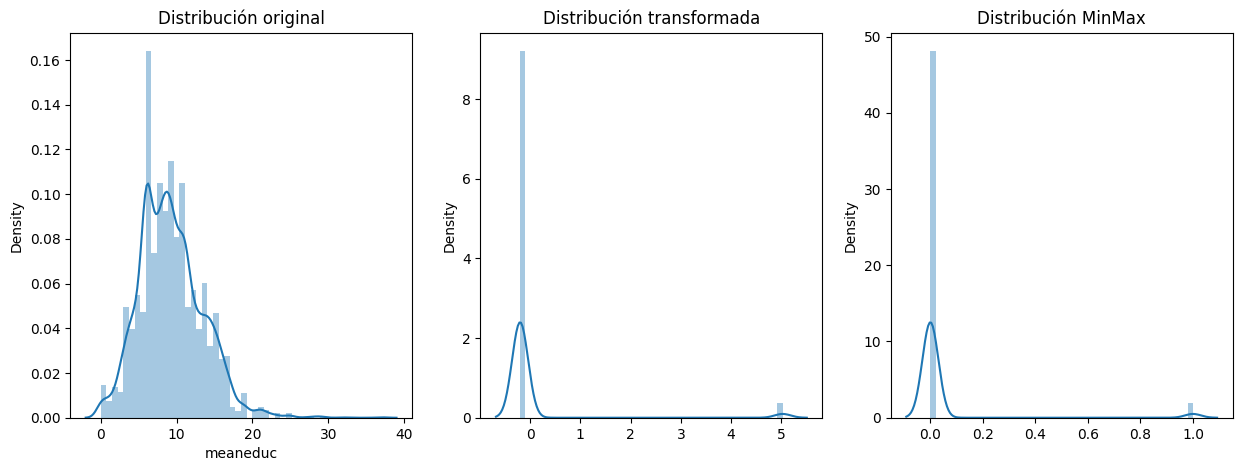

In [65]:
## Ejemplificaremos con una variable lo que hace la transformación

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.distplot(x['meaneduc'], ax=ax[0])
ax[0].set_title('Distribución original')
sns.distplot(x_transformed[:, 0], ax=ax[1])
ax[1].set_title('Distribución transformada')
sns.distplot(x_minmax[:, 0], ax=ax[2])
ax[2].set_title('Distribución MinMax')
plt.show()


In [66]:
## Se correran de nuevo todos los modelos con los datos transformados, para ver si hay mejora en los resultados
log2_f1 = cross_val_score(logreg, x_transformed, y, cv=10, scoring='f1_macro')
print('F1 score para Logistic Regression: ', log2_f1.mean()) 

tree2_f1 = cross_val_score(tree, x_transformed, y, cv=10, scoring='f1_macro')
print('F1 score para Decision Tree: ', tree2_f1.mean())

forest2_f1 = cross_val_score(forest, x_transformed, y, cv=10, scoring='f1_macro')
print('F1 score para Random Forest: ', forest2_f1.mean())

knn2_f1 = cross_val_score(knn, x_transformed, y, cv=10, scoring='f1_macro')
print('F1 score para KNN: ', knn2_f1.mean())





F1 score para Logistic Regression:  0.30139909424835426
F1 score para Decision Tree:  0.32119877861748963
F1 score para Random Forest:  0.34644855264219726
F1 score para KNN:  0.3124206680319208


Usando el estandarScaler de sklearn se procede a estandarizar los datos. Solo mejoro el modelo de regresion logistica, pero muy poco, de 0.26 a 0.31.

In [67]:
log3_f1 = cross_val_score(logreg, x_minmax, y, cv=10, scoring='f1_macro')
print('F1 score para Logistic Regression: ', log3_f1.mean())

tree3_f1 = cross_val_score(tree, x_minmax, y, cv=10, scoring='f1_macro')
print('F1 score para Decision Tree: ', tree3_f1.mean())

forest3_f1 = cross_val_score(forest, x_minmax, y, cv=10, scoring='f1_macro')
print('F1 score para Random Forest: ', forest3_f1.mean())

knn3_f1 = cross_val_score(knn, x_minmax, y, cv=10, scoring='f1_macro')
print('F1 score para KNN: ', knn3_f1.mean())

F1 score para Logistic Regression:  0.31069456804294754
F1 score para Decision Tree:  0.31147283494665184
F1 score para Random Forest:  0.3408611094805734
F1 score para KNN:  0.2925653665527784


En este caso los resultados encontrados son similares a los encontrados utilizando el standarScaler, de los modelos de random forest que fueron los mejores en todos los casos, el que mejor se comporta es el que usa el minMaxScaler, con un f1-score de 0.345. Se procede a optimizar los hiperparametros de este modelo.

# 4. Optimización de hiperparametros

In [68]:
# Numero de arboles en el bosque
n_estimators = [int(x_minmax) for x_minmax in np.linspace(start = 10, stop = 100, num = 10)]
# Numero de niveles en el arbol
max_depth = [int(x_minmax) for x_minmax in np.linspace(1, 20, num = 10)]
max_depth.append(None)
# Numero de caracteristicas a considerar en cada split
max_features = ['auto', 'sqrt']
# Criterio de division
criterion = ['gini', 'entropy']
# Numero de muestras requeridas para dividir un nodo interno
min_samples_split = [2, 5, 10]
# Numero de muestras requeridas para estar en un nodo hoja
min_samples_leaf = [1, 2, 4]
# Crear la cuadricula aleatoria
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features,
               'criterion': criterion,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Busqueda aleatoria de parametros, usando 3 fold cross validation,
# Busca en 100 combinaciones diferentes, y usa todos los nucleos disponibles
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='f1_macro')
# Ajustar el modelo
rf_random.fit(x_minmax, y)
# Mostrar los mejores parametros
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 10,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'entropy'}

In [69]:
forest2 = RandomForestClassifier(n_estimators=30, max_depth=None, min_samples_split=10, min_samples_leaf=1, max_features='sqrt', criterion= 'gini')
forest2_f1 = cross_val_score(forest2, x_minmax, y, cv=10, scoring='f1_macro')
print('F1 score para Random Forest: ', forest2_f1.mean())

F1 score para Random Forest:  0.3296621178591009


Realmente los hiperparametros encontrados son muy similares a los que se usaron por defecto, pero se puede ver que el f1-score mejoro un poco. sin embargo esta mejora es muy pequeña y puede deberse a la aleatoriedad del modelo. Para tratar de mejorar el modelo se procedera a disminuir la dimensionalidad de los datos.

# 5. Reducción de dimensionalidad

In [70]:
redutor = umap.UMAP()
x_reducida = redutor.fit_transform(x_minmax)
print('Dimensiones originales: ', x_minmax.shape)
print('Dimensiones reducidas: ', x_reducida.shape)



Dimensiones originales:  (9557, 137)
Dimensiones reducidas:  (9557, 2)


Observamos que UMAP lo que hizo es disminuir la dimensionalidad de los datos, de 137 a 2, estas dos no tienen significado, pero se puede ver que los datos estan mas separados que antes, por lo que se espera que los modelos se comporten mejor. Se procede a entrenar los modelos con los datos reducidos.

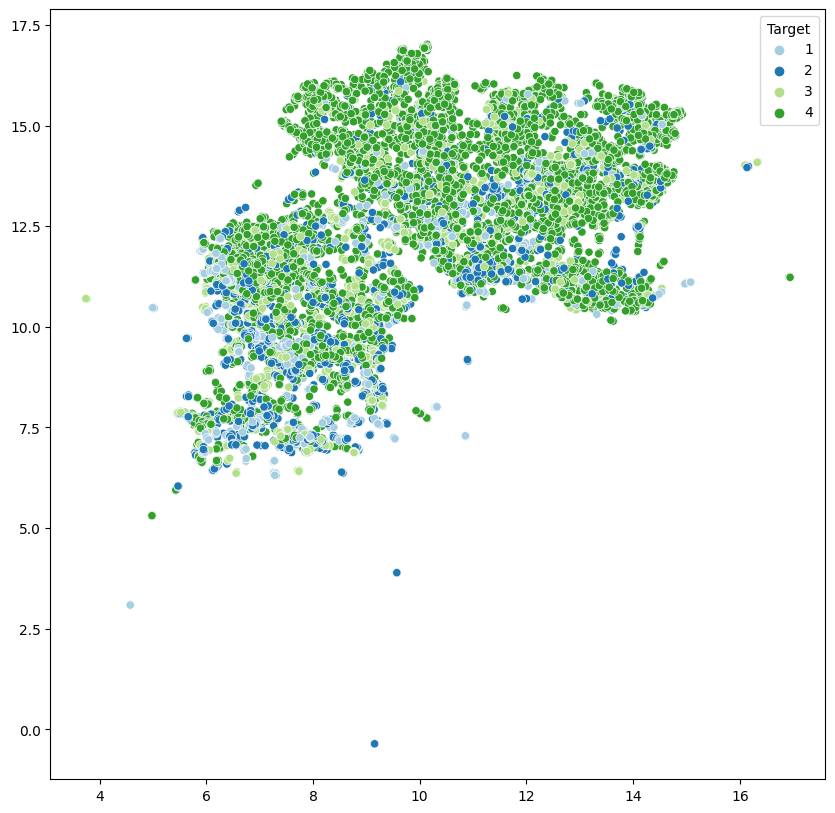

In [71]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=x_reducida[:, 0], y=x_reducida[:, 1], hue=y, palette='Paired')
plt.show()


El grafico anterior, no nos da buenas esperanzas, ya que los datos estan muy mezclados, pero se procede a entrenar los modelos con los datos reducidos.

In [72]:
log2_f1 = cross_val_score(logreg, x_reducida, y, cv=10, scoring='f1_macro')
print('F1 score para Logistic Regression: ', log2_f1.mean())

tree2_f1 = cross_val_score(tree, x_reducida, y, cv=10, scoring='f1_macro')
print('F1 score para Decision Tree: ', tree2_f1.mean())

forest2_f1 = cross_val_score(forest, x_reducida, y, cv=10, scoring='f1_macro')
print('F1 score para Random Forest: ', forest2_f1.mean())

knn2_f1 = cross_val_score(knn, x_reducida, y, cv=10, scoring='f1_macro')
print('F1 score para KNN: ', knn2_f1.mean())



F1 score para Logistic Regression:  0.2516177294565285
F1 score para Decision Tree:  0.28671096795804873
F1 score para Random Forest:  0.28437886479346003
F1 score para KNN:  0.28542934324517405


En general el desepeño de los modelos empeoro, no se usara este metodo para mejorar los modelos.

# 6. Modelos con "boosting"

In [73]:
# Importamos las librerias de xgboost y lightgbm

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier



## a. XGBoost

In [74]:
# El modelo requiere una entrada de forma que comience en 0, debido a como esta construido.

y_xgb = y - 1


In [75]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_f1 = cross_val_score(xgb, x_minmax, y_xgb, cv=10, scoring='f1_macro')
print('F1 score para XGBoost: ', xgb_f1.mean())


F1 score para XGBoost:  0.3041361992641171


## b. LightGBM

In [76]:
lgbm = LGBMClassifier(verbose=-1, random_state=42)
lgbm_f1 = cross_val_score(lgbm, x_minmax, y_xgb, cv=10, scoring='f1_macro')
print('F1 score para LightGBM: ', lgbm_f1.mean())

F1 score para LightGBM:  0.3117778930825262


Probablemente por falta de experiencia optimizando los hiperparametros de los modelos de boosting, no se logro mejorar el f1-score de los modelos. Se procede a usar el modelo de random forest, que fue el que mejor se comporto.

# 7. Curva de aprendizaje del random forest

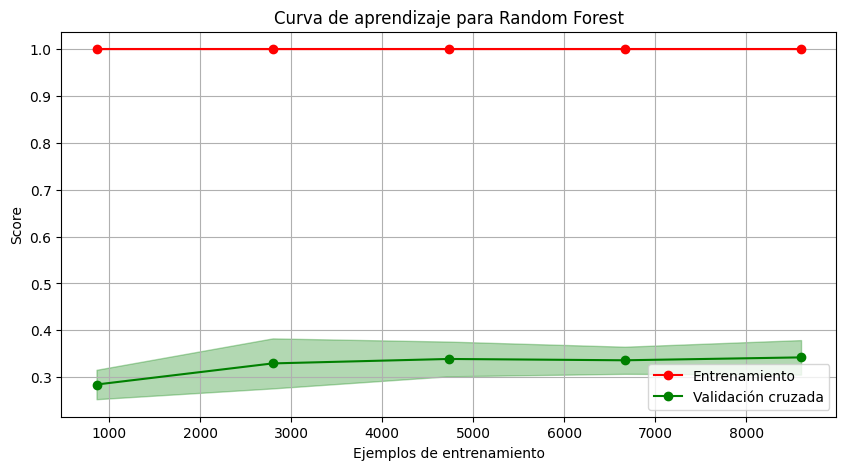

In [80]:
from sklearn.model_selection import learning_curve

# Funcion para graficar la curva de aprendizaje

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    # Generar la grafica
    plt.figure(figsize=(10, 5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Ejemplos de entrenamiento")
    plt.ylabel("Score")
    
    # Generar los valores de la curva de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro')
    
    # Calcular la media y la desviacion estandar
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Graficar los resultados
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.3,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validación cruzada")
    
    plt.legend(loc="best")
    return plt

# Graficar la curva de aprendizaje para el modelo de random forest

plot_learning_curve(forest, 'Curva de aprendizaje para Random Forest', x_minmax, y, cv=10)
plt.show()


Podemos ver que el modelo esta sobreajustado, ya que el score de entrenamiento es muy alto y el de validacion es muy bajo. Las soluciones a este problema son: conseguir mas datos, reducir la complejidad del modelo o aumentar la regularizacion. Sin embargo, con la información conseguida en la competencia, sabemos que el mejor modelo usado obtiene metricas sobre el 0.45, haciendo mas pausible que el problema sea la falta de datos. Se procede a usar el modelo de random forest, que fue el que mejor se comporto.

# 8. Sumisión random forest sin hiperparametros optimizados y minMaxScaler a Kaggle

In [77]:
id = test['Id']
test.drop(['Id', 'idhogar'], axis=1, inplace=True)
test['meaneduc'].fillna(statistics.mode(test['meaneduc']), inplace=True)
test['SQBmeaned'].fillna(test['SQBmeaned'].mean(), inplace=True)
test['dependency'].replace({ 'yes':1, 'no': 0}, inplace=True)
test['edjefe'].replace({ 'yes':1, 'no': 0}, inplace=True)
test['edjefa'].replace({ 'yes':1, 'no': 0}, inplace=True)

test_transformed = MinMaxScaler().fit_transform(test)

tree_final = DecisionTreeClassifier().fit(x_minmax, y)
pred_tree = tree_final.predict(test_transformed)

In [78]:
sumision = pd.DataFrame({'Id': id, 'Target': pred_tree})
sumision.to_csv('sumision.csv', index=False)


El resultado luego de la validación por los datos de Kaggle fue de 0.3445, un resultado muy similar al obtenido en la validación cruzada. Que nos posiciona entre el puesto 300 y 400 de la competencia. Cabe recalcar que el mayor resultado obtenido en la competencia es de 0.45, por lo que se puede decir que el resultado obtenido es aceptable.